# Deep Learning - Convolutional Neural Networks

In this lab, we will explore Convolutional Neural Networks, a deep learning architecture introducted for image processing. In particular, we will build  one of the earliest Convolutional Neural Networks ever introduced, LeNet5. We will build this CNN from scratch in PyTorch, and will also see how it performs on a real-world dataset. We will also compare it with a "standard" NN (and maybe a simple linear model, if time permits).



This is the architecture of LeNet5.
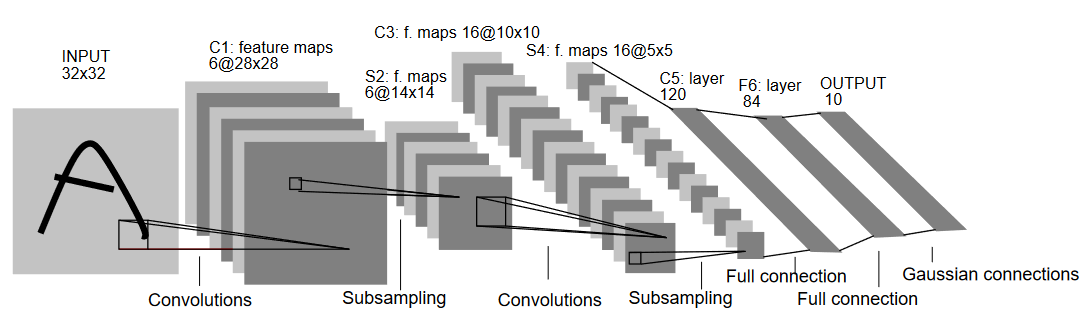

# **Data**
Let's start by loading and analyzing the data. We will be using the MNIST dataset. The MNIST dataset contains images of handwritten numerical digits. The images are greyscale, all with a size of 28x28, and is composed of 60,000 training images and 10,000 testing images.

You can see some of the samples of images below (from https://paperswithcode.com/dataset/mnist)

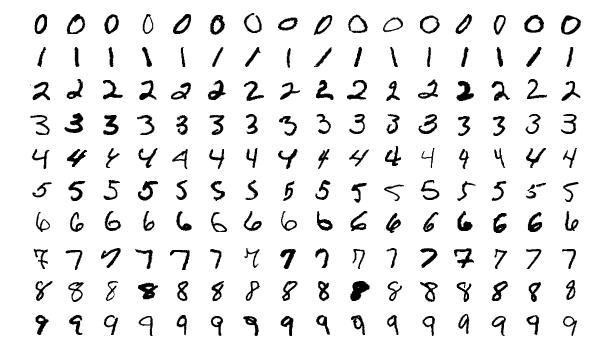



The output is a distribution over the 0-9 digits, that is,
we get the most likely prediction.

# **Importing Libraries**

Let's start by importing the required libraries and defining some variables (hyperparameters and device are also detailed to help the package determine whether to train on GPU or CPU):

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64 # Number of images processed in parallel.
num_classes = 10 # 0-9 digits.
learning_rate = 0.001 # Eta parameter.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using torchvision , we will load the dataset as this will allow us to perform any pre-processing steps easily. This is what we are doing:
1.   The LeNet5 architecture accepts the input to be 32x32 and the MNIST images are 28x28. We  fix this by resizing the images, normalizing them using the pre-calculated mean and standard deviation (available online), and finally storing them as tensors.
2.   We set download=True to download the data the first time we run the code.
3.   We use data loaders. Data loaders allow us to iterate through the data in batches, and the data is loaded while iterating and not at once in start. This may not be important for a dataset of the size of MNIST, but it is for larger datasets.
4.   We specify the batch size and shuffle the dataset when loading so that every batch has some variance in the types of labels it has. This will increase the efficacy of our eventual model.

In [13]:
#Loading the dataset and preprocessing

# Rescale the input img: we need 32x32 in input in order to use the architecture.
# Our images are 28x28, so in order to rescale, we can simply add some
# padding, that is, some zeros pixels until we reach 32x32.
# If the input had been bigger than 32x32 it would have been enough
# to remove some pixels (alternately use a linear scaler).

# Define train dataset.
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)), # Rescale img.
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]), # Also scale the inupt data.
                                           download = True)

# Define test set.
test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                          download=True)


# Define train loader: composed by many set of samples with size bath_size.
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

# Define test loader.
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

Let's now explore the data a little bit by looking at some images.

A sample in the dataset: matrix and label (digit):
(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]), 5) 

The image
tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]])
label: 5


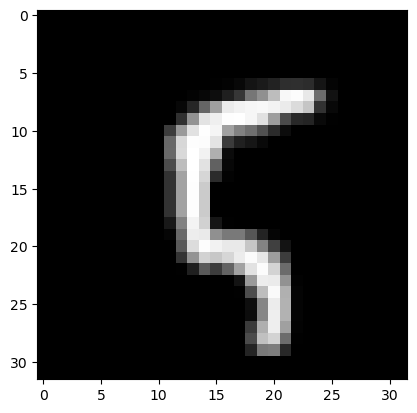

In [14]:
#now let's display some images

import matplotlib.pyplot as plt

print("A sample in the dataset: matrix and label (digit):")
print(train_dataset[100], "\n")

print("The image")
x=train_dataset[100][0][0]
print(x)
plt.imshow(x, cmap='gray')
print("label:",train_dataset[100][1])

Note that by scaling the data, the background is black, the digit is white!

# **Defining a simple CNN architecture**
We are now going to define a very simple CNN to learn how to do it; later, you will define the LeNet architecture.

In [189]:
#Defining the convolutional neural network
# We need to define a class that represent our model.
# nn.Module is the the father class.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes): # num_classes is the number of classes of the output.
        super(SimpleCNN, self).__init__() # Build the model.
        torch.manual_seed(12345) # Set a seed.
        
        # Now define the structure of the network.
        self.layer1 = nn.Sequential( # Sequential layer.
            # Input := 1 because is a matrix (1 channel).
            # Output := 6, number of features.
            # kernel_size := 5, i.e. a 5x5 matrix.
            # stride := 1, move the kernel one pixel at time.
            # padding := 0, do not add extra 0 pixels.
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            
            # Scale again the data (the features) for statistical reason.
            # Its like a layer that scale the data obtained => get more robust net.
            nn.BatchNorm2d(6), 
            
            # Apply relu to all of the features.
            nn.ReLU(), 
            
            # Kernel 2x2 and apply AVG pooling.
            # Stried = 2 => halves the size of the image.
            nn.AvgPool2d(kernel_size = 2, stride = 2)
        ) 
        
        # Create a fully connected network.
        self.fc = nn.Linear(1176, 84) # 1176 = 6x14x14.
        self.relu = nn.ReLU() # Activation funciton.
        self.fc2 = nn.Linear(84, num_classes)

    # x is the inuput.
    def forward(self, x, plot=False):
        # Apply the first layer.
        out = self.layer1(x) 

        # Extra.
        # Plot results after first layer.
        if plot:
            # Move img to cpu.
            # Input img.
            img_num = 0 # Chose first img (total = 64)
            x_cpu = torch.Tensor.cpu(x)[img_num].squeeze() # Chose img 1 out of 64.
            # 6 features.
            out_cpu = [torch.Tensor.cpu(v) for v in out[img_num]] # First dim goes from 0 to 63
                                                                      # Second dim goes from 0 to 5
            out_cpu = [torch.Tensor.detach(v).numpy() for v in out_cpu]

            # Show an input img and the 6 features after layer 1.
            _, axs = plt.subplots(1, 7, figsize=(12, 12))
            axs = axs.flatten()
            for i, (img, ax) in enumerate(zip([x_cpu] + out_cpu, axs)):
                ax.imshow(img, cmap="gray")
                if not i:
                    ax.set_title("Input img")
                else:
                    ax.set_title(f"Feature {i}")
            plt.show()
            plt.close()
 
        # Reshape output, from 2D to 1D (an array).
        # Need this because the input is passed into the first
        # fully connected layer.
        out = out.reshape(out.size(0), -1)
        
        # First fully connected.
        out = self.fc(out) 
        # Apply the activation function.
        out = self.relu(out) 
        # Second fully connected.
        out = self.fc2(out)
 
        if plot:
            _, pred = torch.max(out.data, 1)
            print("Output predicted is:", pred[0].item())
        
        return out

# **Setting Some (Hyper)Parameters**
We now set the loss function, the optimization algorithm, and the number of epochs.


In [190]:
model_simpleCNN = SimpleCNN(num_classes).to(device) # Move everything to GPU.

#Setting the loss function
cost = nn.CrossEntropyLoss() # Used for multi-class.

#Setting the optimizer with the model parameters and learning rate
# Pass paramters of the model and lr := learning rate.
optimizer = torch.optim.Adam(model_simpleCNN.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

#number of epochs
num_epochs = 5

# **Training the Model**
We now train the model using only the training set.

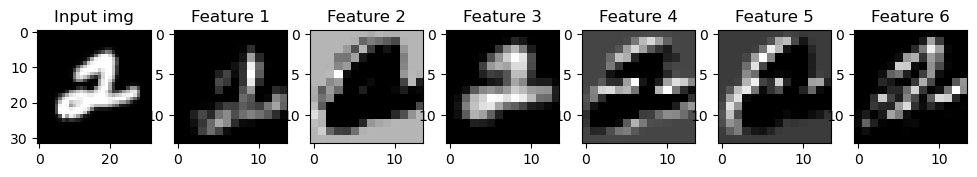

Output predicted is: 5
Epoch [1/5], Step [400/938], Loss: 0.1312
Epoch [1/5], Step [800/938], Loss: 0.0284


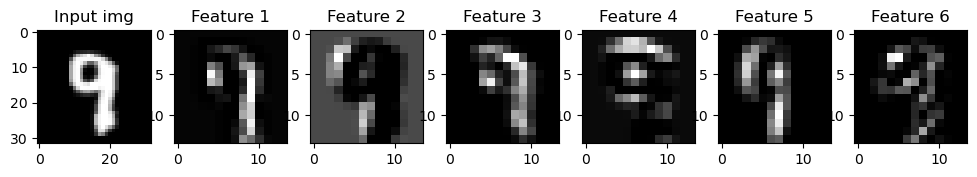

Output predicted is: 9
Epoch [2/5], Step [400/938], Loss: 0.0851
Epoch [2/5], Step [800/938], Loss: 0.0513


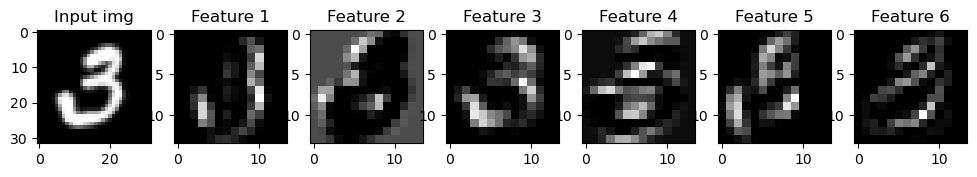

Output predicted is: 3
Epoch [3/5], Step [400/938], Loss: 0.0904
Epoch [3/5], Step [800/938], Loss: 0.0850


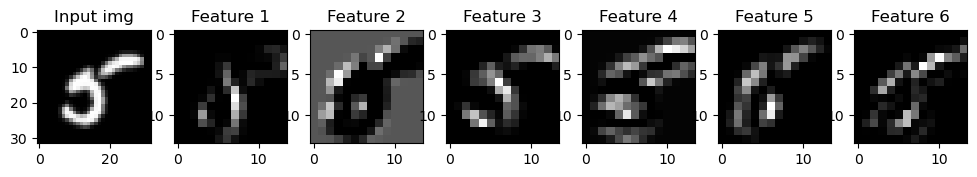

Output predicted is: 5
Epoch [4/5], Step [400/938], Loss: 0.0878
Epoch [4/5], Step [800/938], Loss: 0.0977


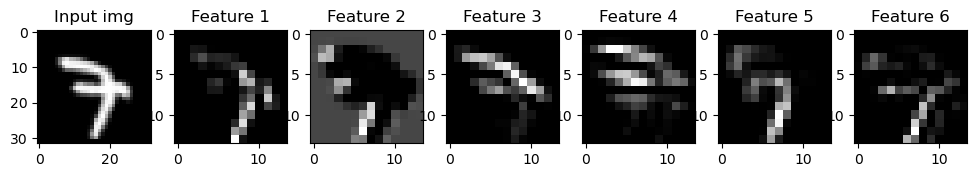

Output predicted is: 7
Epoch [5/5], Step [400/938], Loss: 0.0487
Epoch [5/5], Step [800/938], Loss: 0.0036


In [191]:
total_step = len(train_loader) # 64 images coupled with 64 labels.
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move the data in the GPU.
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass: make the prediction.
        # If i == 0, then plot input an input img and the feature learned.
        plot = False
        if not i:
            plot = True
        outputs = model_simpleCNN(images, plot=plot) # Get predictions.
        loss = cost(outputs, labels) # Compute the costs.

        # Backward and optimize
        optimizer.zero_grad() # Compute the gradient for current batch.
        loss.backward() # Compute back propagation (sensitivity vec)
        optimizer.step() # Update the weights.

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# **Testing the Model**
We now assess the performance of our model on test data


In [163]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad(): # Do not compute gradients.
    correct = 0
    total = 0
    for images, labels in test_loader:

        # Move data to GPU.
        images = images.to(device)
        labels = labels.to(device)

        # Predict output.
        outputs = model_simpleCNN(images)

        # Check if prediction is correct.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the score.
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.68 %


# **COMPLETE: Define the LeNet architecture**
You should now repeat the steps above to define the LeNet architecture, train it, and test it.

In [167]:
class LeNet(nn.Module):
    def __init__(self, num_classes): # num_classes is the number of classes of the out layer.
        super(LeNet, self).__init__() # Build the model.
        torch.manual_seed(231121) # Set a seed.
        
        # Now define the structure of the network: similar to the previous one.
        self.layer1 = nn.Sequential( # Sequential layer 
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)
        )

        # New part.
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)
          )

        # Create a fully connected network.
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU() # Activation funciton.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):  # x is the input.
        out = self.layer1(x) # Apply first layer.
        out = self.layer2(out) # Apply second layer.
        out = out.reshape(out.size(0), -1) # Reshape output: from 2D to 1D.
        out = self.fc(out) # Fully connected 1
        out = self.relu(out) # Apply relu.
        out = self.fc2(out) # Fully connected 2
        out = self.relu(out) # Apply relu.
        out = self.fc3(out) # Fully connected 3
        return out

# **Setting Some (Hyper)Parameters**
We now set the loss function, the optimization algorithm, and the number of epochs. You can set parameters as above, maybe try increasing the number of epochs to 5 or 10.


In [172]:
model_LeNet = LeNet(num_classes).to(device) # Move everything to GPU.

#Setting the loss function
cost = nn.CrossEntropyLoss() # Used for multi-class.

#Setting the optimizer with the model parameters and learning rate
# Pass paramters of the model and lr := learning rate.
optimizer = torch.optim.Adam(model_LeNet.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

#number of epochs
num_epochs = 5

# **Training the Model**
We now train the model using only the training set.

In [173]:
total_step = len(train_loader) # 64 images coupled with 64 labels.
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move the data in the GPU.
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass: make the prediction.
        outputs = model_LeNet(images) # Get predictions.
        loss = cost(outputs, labels) # Compute the costs.

        # Backward and optimize
        optimizer.zero_grad() # Compute the gradient for current batch.
        loss.backward() # Compute back propagation (sensitivity vec)
        optimizer.step() # Update the weights.

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [400/938], Loss: 0.1427
Epoch [1/5], Step [800/938], Loss: 0.0153
Epoch [2/5], Step [400/938], Loss: 0.0297
Epoch [2/5], Step [800/938], Loss: 0.0390
Epoch [3/5], Step [400/938], Loss: 0.0134
Epoch [3/5], Step [800/938], Loss: 0.0630
Epoch [4/5], Step [400/938], Loss: 0.0133
Epoch [4/5], Step [800/938], Loss: 0.0069
Epoch [5/5], Step [400/938], Loss: 0.0385
Epoch [5/5], Step [800/938], Loss: 0.0666


# **Testing the Model**
We now assess the performance of our model on test data



In [174]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad(): # Do not compute gradients.
    correct = 0
    total = 0
    for images, labels in test_loader:

        # Move data to GPU.
        images = images.to(device)
        labels = labels.to(device)

        # Predict output.
        outputs = model_LeNet(images)

        # Check if prediction is correct.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the score.
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.11 %


**Question**

How many parameters (approximately) does the LeNet5 model have?

In [175]:
print("Number of parameters (approximately):")
(6 * 5 * 5) + (16 * 5 * 5) + (16 * 5 * 5 * 120) + (120 * 84) + (84 * 10)

Number of parameters (approximately):


59470

In [176]:
# This function allows to compute the total amount of parameters of a given torch model
def model_params(model):
  # in the following, numel() returns the total number of elements in tensor p
  # see torch documentation for more info
  total_params = sum(p.numel() for p in model.parameters())
  return total_params

In [177]:
# Let's actually verify the overall number of parameters of LeNet5
print(f"Total number of parameters in LeNet5: {model_params(model_LeNet)}")

Total number of parameters in LeNet5: 61750


# **COMPLETE**

Now define, train, and test a simple NN with 1 hidden layer and number of parameters (approximately) similar to LeNet5.

In [178]:
# Define a simple NN with 1 hidden layer.
class NN1h(nn.Module):
    def __init__(self, num_classes): # num_classes is the number of classes of the output.
        super(NN1h, self).__init__() # Build the model.
        torch.manual_seed(435345) # Set a seed.
        
        # Now define the structure of the network.
        self.fc = nn.Linear(1024, 60) # Input is 32x32 = 1024
        self.relu = nn.ReLU() # Activation funciton.
        self.fc2 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = x.reshape(x.size(0), -1) # From 2D in 1D.
        out = self.fc(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [179]:
model_NN1h = NN1h(num_classes).to(device) # Move everything to GPU.

#Setting the loss function
cost = nn.CrossEntropyLoss() # Used for multi-class.

#Setting the optimizer with the model parameters and learning rate
# Pass paramters of the model and lr := learning rate.
optimizer = torch.optim.Adam(model_NN1h.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

#number of epochs
num_epochs = 5

In [180]:
# Train the model.
total_step = len(train_loader) # 64 images coupled with 64 labels.
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move the data in the GPU.
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass: make the prediction.
        outputs = model_NN1h(images) # Get predictions.
        
        loss = cost(outputs, labels) # Compute the costs.

        # Backward and optimize
        optimizer.zero_grad() # Compute the gradient for current batch.
        loss.backward() # Compute back propagation (sensitivity vec)
        optimizer.step() # Update the weights.

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [400/938], Loss: 0.3493
Epoch [1/5], Step [800/938], Loss: 0.1641
Epoch [2/5], Step [400/938], Loss: 0.1551
Epoch [2/5], Step [800/938], Loss: 0.3093
Epoch [3/5], Step [400/938], Loss: 0.0589
Epoch [3/5], Step [800/938], Loss: 0.0396
Epoch [4/5], Step [400/938], Loss: 0.0078
Epoch [4/5], Step [800/938], Loss: 0.0527
Epoch [5/5], Step [400/938], Loss: 0.0141
Epoch [5/5], Step [800/938], Loss: 0.0644


In [181]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad(): # Do not compute gradients.
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Move data to GPU.
        images = images.to(device)
        labels = labels.to(device)

        # Predict output.
        outputs = model_NN1h(images)

        # Check if prediction is correct.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the score.
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 97.21 %


# **COMPLETE**

Now define, train, and test a simple linear model.

In [182]:
# Define a simple Linear model.
class SimpleLinear(nn.Module):
    def __init__(self, num_classes): # num_classes is the number of classes of the output.
        super(SimpleLinear, self).__init__() # Build the model.
        torch.manual_seed(234234) # Set a seed.
        
        # Now define the structure of the network.
        self.fc = nn.Linear(1024, num_classes) # Input is 32x32 = 1024

    def forward(self, x):
        x = x.reshape(x.size(0), -1) # From 2D in 1D.
        out = self.fc(x)
        return out

In [183]:
model_linear = SimpleLinear(num_classes).to(device) # Move everything to GPU.

#Setting the loss function
cost = nn.CrossEntropyLoss() # Used for multi-class.

#Setting the optimizer with the model parameters and learning rate
# Pass paramters of the model and lr := learning rate.
optimizer = torch.optim.Adam(model_linear.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

#number of epochs
num_epochs = 5

In [184]:
# Train the model.
total_step = len(train_loader) # 64 images coupled with 64 labels.
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move the data in the GPU.
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass: make the prediction.
        outputs = model_linear(images) # Get predictions.
        
        loss = cost(outputs, labels) # Compute the costs.

        # Backward and optimize
        optimizer.zero_grad() # Compute the gradient for current batch.
        loss.backward() # Compute back propagation (sensitivity vec)
        optimizer.step() # Update the weights.

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [400/938], Loss: 0.2538
Epoch [1/5], Step [800/938], Loss: 0.2442
Epoch [2/5], Step [400/938], Loss: 0.2298
Epoch [2/5], Step [800/938], Loss: 0.1133
Epoch [3/5], Step [400/938], Loss: 0.3250
Epoch [3/5], Step [800/938], Loss: 0.3419
Epoch [4/5], Step [400/938], Loss: 0.3572
Epoch [4/5], Step [800/938], Loss: 0.2496
Epoch [5/5], Step [400/938], Loss: 0.2990
Epoch [5/5], Step [800/938], Loss: 0.0797


In [185]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad(): # Do not compute gradients.
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Move data to GPU.
        images = images.to(device)
        labels = labels.to(device)

        # Predict output.
        outputs = model_linear(images)

        # Check if prediction is correct.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the score.
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 92.33 %
